In [44]:
import pprint
import requests
import json
import time
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os

In [2]:
pp = pprint.PrettyPrinter(indent=2)

### Riot API Status Code List
- 400	Bad request
- 401	Unauthorized
- 403	Forbidden
- 404	Data not found
- 405	Method not allowed
- 415	Unsupported media type
- 429	Rate limit exceeded
- 500	Internal server error
- 502	Bad gateway
- 503	Service unavailable
- 504	Gateway timeout

In [4]:
class TFTData:
    def __init__(self):
        self.token = "RGAPI-59b27655-d81f-41aa-a925-988ecc9962cd"
        self.header = {
            'X-Riot-Token': self.token
        }
        self.puu_ids = []
        self.match_ids = []
        self.all_match_data = []
        self.request_counter = 0

    def send_request(self, url):
        retry = 0
        try:
            res = requests.get(url, headers=self.header)
            if res.status_code == 429:
                if retry == 0:
                    time.sleep(1.5)
                    retry = retry + 1
                if retry == 1:
                    time.sleep(1.5)
                    retry = retry + 1
                if retry == 2:
                    print('Request Rate Limit Exceeded Waiting 130 seconds...')
                    time.sleep(130)
                    retry = retry + 1
                else:
                    print(f'Failed Request: {url}')
                    return None
                res = requests.get(url, headers=self.header)

            if res.status_code != 200:
                print(f"Request Failed : {res.status_code}")
                return None
            return res

        except:
            print("Exception while send API request")
            return None
        
    def get_summoner_names(self, tier='challenger', region='na1'):
        """
        Get list of summoner names in the region
        Arguments:
            region(String)
        Returns: 
            summoner_names(List)
        """
        url = f'https://{region}.api.riotgames.com/tft/league/v1/{tier}'
        res = self.send_request(url)
        summoner_names = []
        for summoner in res.json()['entries']:
            summoner_names.append(summoner['summonerName'])
        
        return summoner_names
    
    def get_puu_id(self, summoner_name, region='na1'):
        """
        Get an puuid of id, puuid is required to get match data
        Arguments:
            region(String)
            summoner_name(String)
        Returns:
            puu_id(String)
        """
        url = f'https://{region}.api.riotgames.com/tft/summoner/v1/summoners/by-name/{summoner_name}'
        res = self.send_request(url)
        puu_id = res.json()['puuid']

        return puu_id

    def get_puu_ids(self, summoner_names, region='na1'):
        """
        Get list of puu_id for each with provided list of ids
        Arguments:
            region(String)
            summoner_names(List)
        Returns:
            puu_ids(List): list of puu_ids matching with provided ids
        """
        puu_ids = []
        for name in summoner_names:
            self.puu_ids.append(self.get_puu_id(name, region))
    
    def get_user_match_ids(self, puu_id, region='na1', count=20):
        url = f'https://{region}.api.riotgames.com//tft/match/v1/matches/by-puuid/{puu_id}/ids?count={count}'
        res = self.send_request(url)
    
        return res.json()
    
    def get_match_data(self, match_id, region='americas'):
        url = f'https://americas.api.riotgames.com/tft/match/v1/matches/{match_id}'
        res = self.send_request(url)
        
        return res.json()
    
    def get_n_matches(self, region='na1', tier='challenger', count=20):
        """
        Get list of match ids with provided conditions
        """
        print(f'Getting summners names\n region:{region} tier: {tier}')
        summoner_names = self.get_summoner_names(tier, region)
        print(f'Getting puu_ids for #{len(summoner_names)} summoners')
        self.get_puu_ids(summoner_names, region)
        #self.get_puu_ids(summoner_names[:10], region)

        print(f'Getting match data from #{len(self.puu_ids)} puu_ids')
        for index, id in enumerate(self.puu_ids):
            # will need to handle region change (na1 -> america)
            # if region in america -> america .... 
            if index%10 == 0:
                print(f'Getting {index}th id match data...')
            self.match_ids = list(set(self.match_ids + self.get_user_match_ids(puu_id=id, region='americas', count=count)))

        for id in self.match_ids:
            # Region handling
            self.all_match_data.append(self.get_match_data(match_id=id))
        print('Data Pulling Done')
        print(f'Number of Matches: {len(self.all_match_data)}')
        
        # Store the match ids
        file_name = f"../data/{str(datetime.date.today())}_{tier}_{region}_match_ids.p"
        pickle_data(self.all_match_data, file_name)

        # Store the data
        file_name = f"../data/{str(datetime.date.today())}_{tier}_{region}_match_data.p"
        pickle_data(self.all_match_data, file_name)
           
    def pickle_data(self, data, file_name):
        print(f"Pickling Data\n File: {file_name}")
        try:    
            output_file = open(file_name, "wb")
            pickle.dump(data, output_file)
            output_file.close()

        except:
            print('Exception While Pickling')
            
# App = TFTData()
# App.get_n_matches(count=100)

In [9]:
# Load stored data
open_file = open("../data/2020-05-25_challenger_na1_match_data.p", 'rb')
sample_data = pickle.load(open_file)
sample_data[0]

App = TFTData()
App.all_match_data = sample_data

In [221]:
# Example converting game_datetime to readable format
sample_datetime = '1589564943684'
your_dt = datetime.datetime.fromtimestamp(int(sample_datetime)/1000)  # using the local timezone
print(your_dt.strftime("%Y-%m-%d"))

2020-05-15


In [11]:
def get_units_in_single_match(single_match_data):
    """
    Extract all unit data from single match data
    Arguments: 
        single_match_data(Dict): response from Riot API match details
    Returns:
        units(List): All units used in match
    """
    players = single_match_data['info']['participants']
    units = []
    for p in players:
        units += p['units']

    return units


def get_units_in_multi_match(multi_match_data):
    """
    Get unit data from list of multiple matches
    Arguments:
        multi_match_data(List):
    Returns:
        units(List)
    """
    units = []
    for match in multi_match_data:
        units = units + get_units_in_single_match(match)
    
    return units

def get_units_from_player_list(player_list):
    """
    Extract all unit data from list of player data
    Arguments:
        player_list(List): list of player data(dict)
    Returns:
        unit_list(List): list of unit data
    """
    units = []
    for player in player_list:
        units += player['units']
    
    return units
    
def get_unit_hashtable(unit_list):
    """
    Build unit hashtable
    Arguments:
        unit_list(List): list of all units used in game
    Returns:
        unit_hash(Dict): 
            Key(String): name of units
            Value(List): detail information of each units
    """
    unit_hash = {}

    for unit in unit_list:
        unit_name = unit['character_id'][5:]
        if unit_name not in unit_hash.keys():
             unit_hash[unit_name] = [unit]
        else:
             unit_hash[unit_name].append(unit)
    
    return unit_hash

In [12]:
units_single_match = get_units_in_single_match(sample_data[0])
print(f'units_single_match: {len(units_single_match)}')
units_multi_match = get_units_in_multi_match(sample_data)
print(f'units_multi_match: {len(units_multi_match)}')

unit_hashtable = get_unit_hashtable(units_multi_match)

units_single_match: 75
units_multi_match: 442362


In [14]:
def build_hashtable_from_list(lst):
    """
    Create hashtable from list
    Arguments:
        input(List): elements to build hashtable in list format
    Returns:
        (Dict): hashtable of items
            key: name of element
            val: count of element
    """
    table = {}
    for e in lst:
        if e not in table.keys():
            table[e] = 1
        else:
            table[e] += 1

    return table


def build_unit_use_count_tier_item_df(unit_hashtable):
    '''
    Build dataframe for unit useage analysis
    Arguments:
        unit_hashtable(Dict): result from unit_dict_in_multi_match function.
    Returns:
        unit_use_count_tier_item_df(dataFrame): |name(String) | use_count(Int) | tiers(List) | items(List)|
    
    sample single unit data :
    { 
        'character_id': 'TFT3_Fiora',
        'items': [59],
        'name': '',
        'rarity': 0,
        'tier': 1
    }
    '''
    unit_use_count_tier_item = []
    for champ_name, list_of_units in unit_hashtable.items():
        champ_tier_list = []
        champ_item_list = []
        for unit in list_of_units:
            champ_tier_list.append(unit['tier'])
            items = unit['items']
            if 99 in items:
                champ_item_list += [99] # 99: Thief's Gloves: generates 2 random item
            else:
                champ_item_list += unit['items']
        
        champ_tier_table = build_hashtable_from_list(champ_tier_list)
        champ_item_table = build_hashtable_from_list(champ_item_list)
        unit_use_count_tier_item.append([champ_name, len(list_of_units), champ_tier_table, champ_item_table])
    
    
    unit_use_count_tier_item_df = pd.DataFrame(unit_use_count_tier_item, columns = ['Champion', 'Count', 'Tier', 'Item']) 
    return unit_use_count_tier_item_df

unit_use_count_tier_item_df = build_unit_use_count_tier_item_df(unit_hashtable)
print(unit_use_count_tier_item_df.head())

   Champion  Count                         Tier  \
0  JarvanIV   9020   {2: 3422, 3: 4990, 1: 608}   
1     Shaco   7911   {2: 5616, 3: 1797, 1: 498}   
2  Kassadin  17479  {2: 13820, 1: 3244, 3: 415}   
3     Karma   8717   {2: 6815, 1: 1799, 3: 103}   
4      Ashe  11183   {2: 9038, 1: 1880, 3: 265}   

                                                Item  
0  {66: 240, 3: 475, 33: 1565, 47: 1247, 35: 1376...  
1  {55: 151, 45: 919, 19: 1059, 57: 193, 12: 417,...  
2  {89: 106, 47: 1309, 37: 300, 18: 169, 23: 43, ...  
3  {17: 757, 47: 129, 34: 66, 33: 245, 44: 198, 4...  
4  {89: 442, 57: 162, 26: 203, 44: 75, 4: 59, 29:...  


In [15]:
def add_average_tier_on_unit_df(df):
    """
    Enrich the dataFrame with average tier of units column
    Argumnets:
        df(dataFrame): result dataframe from 'build_unit_use_count_tier_item_df' function
    Returns:
        df(dataFrame): df enriched with Average_Tier column
    """

    def calculate_average_tier(cnt, tier_hash):
        """
        Calculate average of tier
        Arguments:
            tier_dict(Dict)
        Returns:
            average_tier(Float)
        """
        sum = 0
        for key, val in tier_hash.items():
            sum += (int(key) * int(val))

        return sum/cnt
            
    df['Average_Tier'] = df.apply(lambda row: calculate_average_tier(row.Count, row.Tier), axis=1)
    
    return df

sample_data_w_avg_tier = add_average_tier_on_unit_df(unit_use_count_tier_item_df)
sample_data_w_avg_tier.head()

,Champion,Count,Tier,Item,Average_Tier
0,JarvanIV,9020,"{2: 3422, 3: 4990, 1: 608}","{66: 240, 3: 475, 33: 1565, 47: 1247, 35: 1376...",2.485809
1,Shaco,7911,"{2: 5616, 3: 1797, 1: 498}","{55: 151, 45: 919, 19: 1059, 57: 193, 12: 417,...",2.164202
2,Kassadin,17479,"{2: 13820, 1: 3244, 3: 415}","{89: 106, 47: 1309, 37: 300, 18: 169, 23: 43, ...",1.838149
3,Karma,8717,"{2: 6815, 1: 1799, 3: 103}","{17: 757, 47: 129, 34: 66, 33: 245, 44: 198, 4...",1.805438
4,Ashe,11183,"{2: 9038, 1: 1880, 3: 265}","{89: 442, 57: 162, 26: 203, 44: 75, 4: 59, 29:...",1.855584


In [16]:
def add_average_num_item_on_unit_df(df):
    """
    Enrich the dataFrame with average number of item column
    Argumnets:
        df(dataFrame): result dataframe from 'build_unit_use_count_tier_item_df' function
    Returns:
        df(dataFrame): df enriched with Average_Num_Item column
    """
    def calculate_average_num_item(cnt, item_hash):
        """
        Calculate average of tier
        Arguments:
            item_dict(Dict)
        Returns:
            average_num_item(Float)
        """
        sum = 0
        for val in item_hash.values():
            sum += int(val)

        return sum/cnt
            
    df['Average_Num_Item'] = df.apply(lambda row: calculate_average_num_item(row.Count, row.Item), axis=1)
    return df

sample_data_w_avg_item = add_average_num_item_on_unit_df(unit_use_count_tier_item_df)
sample_data_w_avg_item.head()

,Champion,Count,Tier,Item,Average_Tier,Average_Num_Item
0,JarvanIV,9020,"{2: 3422, 3: 4990, 1: 608}","{66: 240, 3: 475, 33: 1565, 47: 1247, 35: 1376...",2.485809,1.333038
1,Shaco,7911,"{2: 5616, 3: 1797, 1: 498}","{55: 151, 45: 919, 19: 1059, 57: 193, 12: 417,...",2.164202,1.673113
2,Kassadin,17479,"{2: 13820, 1: 3244, 3: 415}","{89: 106, 47: 1309, 37: 300, 18: 169, 23: 43, ...",1.838149,0.454202
3,Karma,8717,"{2: 6815, 1: 1799, 3: 103}","{17: 757, 47: 129, 34: 66, 33: 245, 44: 198, 4...",1.805438,0.394058
4,Ashe,11183,"{2: 9038, 1: 1880, 3: 265}","{89: 442, 57: 162, 26: 203, 44: 75, 4: 59, 29:...",1.855584,0.387284


In [17]:
def add_unit_percent_on_df(df):
    """
    Enrich the dataFrame with unit usage percentage
    Use_Percent = Count / sum(Count)
    Argumnets:
        df(dataFrame): result dataframe from 'build_unit_use_count_tier_item_df' function
    Returns:
        df(dataFrame): df enriched with Use_Percent column
    """
    total_unit_count = sum(df['Count'])
    df['Percent'] = df.apply(lambda row: (row.Count/total_unit_count)*100, axis=1)
    
    return df

sample_data_with_percent = add_unit_percent_on_df(unit_use_count_tier_item_df)
sample_data_with_percent.head()

,Champion,Count,Tier,Item,Average_Tier,Average_Num_Item,Percent
0,JarvanIV,9020,"{2: 3422, 3: 4990, 1: 608}","{66: 240, 3: 475, 33: 1565, 47: 1247, 35: 1376...",2.485809,1.333038,2.039054
1,Shaco,7911,"{2: 5616, 3: 1797, 1: 498}","{55: 151, 45: 919, 19: 1059, 57: 193, 12: 417,...",2.164202,1.673113,1.788354
2,Kassadin,17479,"{2: 13820, 1: 3244, 3: 415}","{89: 106, 47: 1309, 37: 300, 18: 169, 23: 43, ...",1.838149,0.454202,3.951289
3,Karma,8717,"{2: 6815, 1: 1799, 3: 103}","{17: 757, 47: 129, 34: 66, 33: 245, 44: 198, 4...",1.805438,0.394058,1.970558
4,Ashe,11183,"{2: 9038, 1: 1880, 3: 265}","{89: 442, 57: 162, 26: 203, 44: 75, 4: 59, 29:...",1.855584,0.387284,2.528020


In [68]:
def build_item_usage_df(item_col):
    """
    Build item usage dataFrame
    Arguments:
        item_col(dataFrame): the 'Item' column from unit_use_count_tier_tiem_df
    Returns:
        item_usage_df(dataFrame):
    """

    # Count all item usage
    item_usage_df = {}
    for row in item_col:
        for item_id, item_cnt in row.items():
            if item_id not in item_usage_df.keys():
                item_usage_df[item_id] = item_cnt
            else:
                item_usage_df[item_id] += item_cnt
    
    # Load item_id and item_name dict
    with open('../config/set3/items.json') as f:
        item_id_name = json.load(f)

    # Add item name to df
    for item_id, item_cnt in item_usage_df.items():
        for item in item_id_name:
            if str(item['id']) == str(item_id):
                item['count'] = item_cnt
                break
    
    return pd.DataFrame(item_id_name, columns=['id', 'name', 'count'])

item_id_name_cnt_df = build_item_usage_df(unit_use_count_tier_item_df['Item'])
item_id_name_cnt_df.sort_values(by=['count'], ascending=False)

,id,name,count
13,15,Guardian Angel,29135
47,69,Quicksilver,23682
17,19,Infinity Edge,20284
33,44,Seraph's Embrace,19000
29,36,Ionic Spark,18744
25,29,Last Whisper,18038
30,37,Morellonomicon,17833
19,23,Guinsoo's Rageblade,16975
41,57,Red Buff,16543
36,47,Redemption,14146


In [229]:
def split_match_data_win_and_lose(match_data):
    """
    Split match data into winner and lower group
    Arguments:
        match_data(List)
    Returns:
        winner(List): list of winner participant data
        lower(List): list of loser participant data 
    """
    winner = []
    loser = []
    for match in match_data:
        participants = match['info']['participants']
        for p in participants:
            if p['placement'] >= 4:
                winner.append(p)
            else:
                loser.append(p)
    return [winner, loser]

winner_match_data, loser_match_data = split_match_data_win_and_lose(sample_data)

In [230]:
winner_unit_list = get_units_from_player_list(winner_match_data)
loser_unit_list = get_units_from_player_list(loser_match_data)

winner_match_hashtable = get_unit_hashtable(winner_unit_list)
loser_match_hashtable  = get_unit_hashtable(loser_unit_list)

winner_unit_use_count_tier_item_df = build_unit_use_count_tier_item_df(winner_match_hashtable)
loser_unit_use_count_tier_item_df = build_unit_use_count_tier_item_df(loser_match_hashtable)

winner_unit_use_count_tier_item_df.to_csv("sample_winner_unit_use_count_tier_item_df.csv")

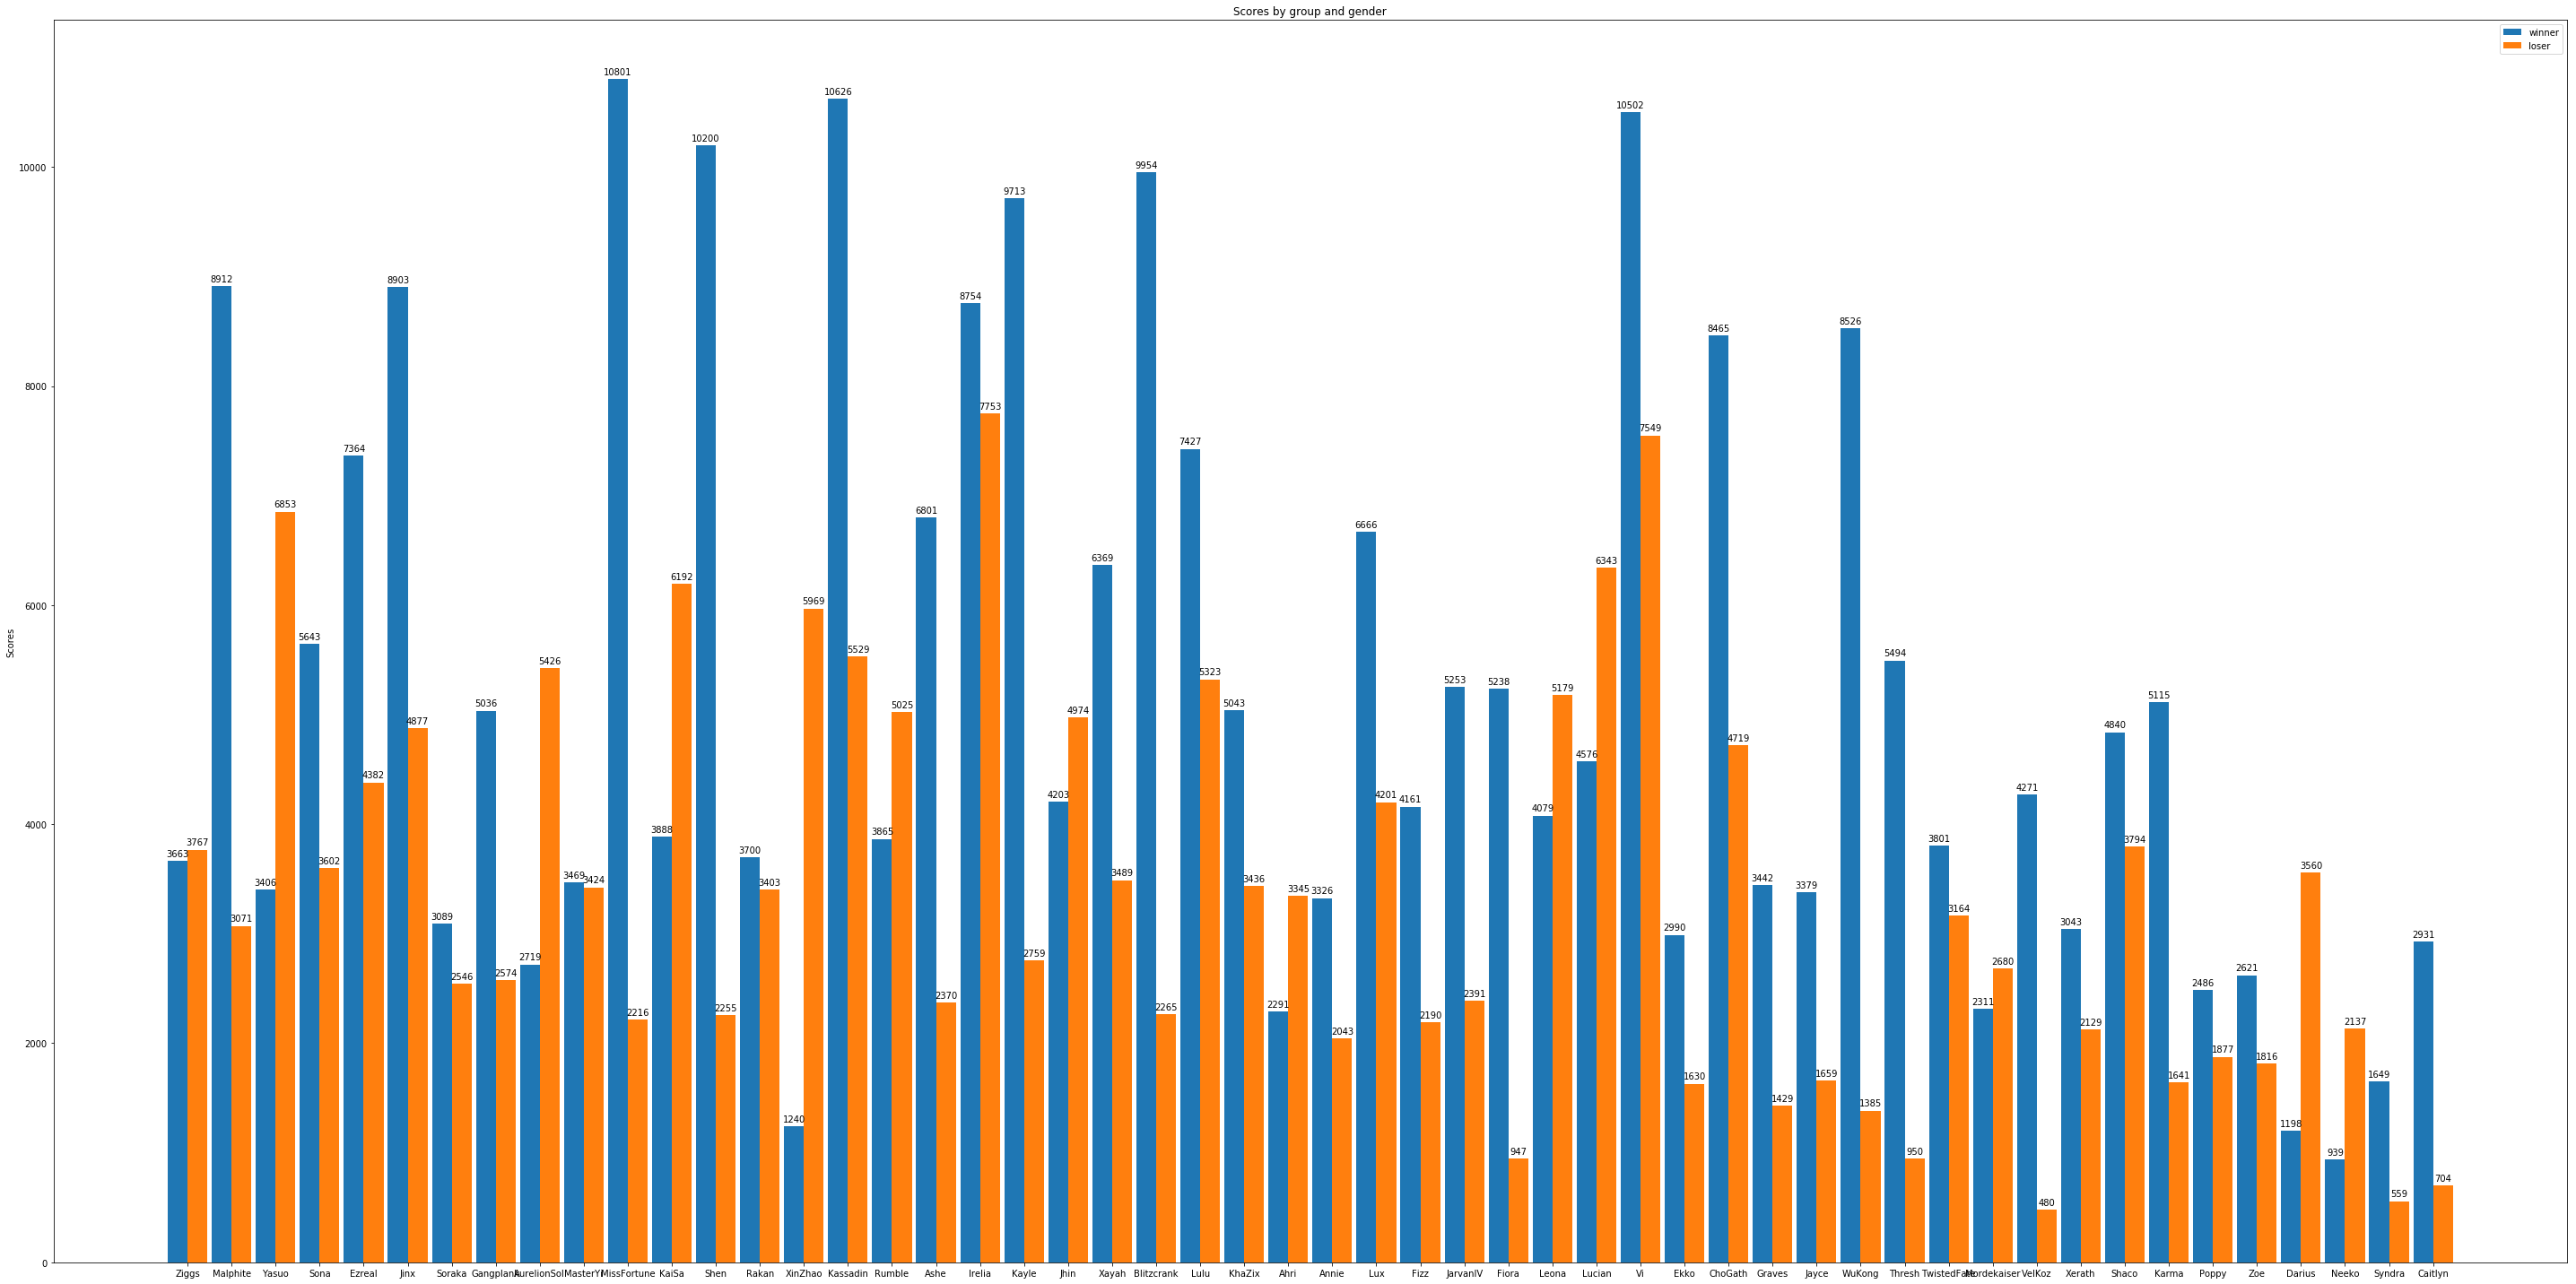

In [232]:
from matplotlib.pyplot import figure
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')


labels = list(winner_unit_use_count_tier_item_df['Champion'])
winner_units = list(winner_unit_use_count_tier_item_df['Count'])
loser_units = list(loser_unit_use_count_tier_item_df['Count'])

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(40,20))

rects1 = ax.bar(x - width/2, winner_units, width, label='winner')
rects2 = ax.bar(x + width/2, loser_units, width, label='loser')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


#plt.show()
plt.savefig('winner_loser_unit_compare.png')
